In [1]:
import pandas as pd
import tensorflow as tf
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

import matplotlib.pyplot as plt
from utils.plt_setting import plt_settings
from utils.evaluation import regression_evaluation, f_importances, plot_actual_pred
from utils.data_manager import read_data

# 한글처리 지원
plt_settings()

2023-10-16 10:35:54.342277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_X = read_data('2a-all-scaled-X')
df_y = read_data('2a-all-y')

training_columns = df_X.columns

In [3]:
X_train, X_test, y_train, y_test = \
    train_test_split(df_X, df_y, test_size=0.2)

In [4]:
model_mlp = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1:])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model_mlp.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               19072     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29441 (115.00 KB)
Trainable params: 29441 (115.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-10-16 10:36:00.088648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22817 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:5e:00.0, compute capability: 7.5
2023-10-16 10:36:00.089635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22248 MB memory:  -> device: 1, name: NVIDIA TITAN RTX, pci bus id: 0000:af:00.0, compute capability: 7.5


In [5]:
history = model_mlp.fit(
    X_train, y_train, 
    epochs=100, verbose=2, validation_split=0.2
)

Epoch 1/100


2023-10-16 10:36:03.221390: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6904010d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-16 10:36:03.221440: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN RTX, Compute Capability 7.5
2023-10-16 10:36:03.221448: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA TITAN RTX, Compute Capability 7.5
2023-10-16 10:36:03.257112: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-16 10:36:03.649226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-16 10:36:03.741033: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-16 10:36:03.876428: I ./tensorflow/compiler/jit/device_comp

228/228 - 6s - loss: 27213932003328.0000 - mae: 4220007.0000 - val_loss: 26723139715072.0000 - val_mae: 4208435.5000 - 6s/epoch - 27ms/step
Epoch 2/100
228/228 - 2s - loss: 23707833597952.0000 - mae: 3961068.0000 - val_loss: 18011484323840.0000 - val_mae: 3514034.0000 - 2s/epoch - 8ms/step
Epoch 3/100
228/228 - 2s - loss: 13261129908224.0000 - mae: 2836867.2500 - val_loss: 9600841547776.0000 - val_mae: 2321634.5000 - 2s/epoch - 8ms/step
Epoch 4/100
228/228 - 2s - loss: 8137727803392.0000 - mae: 1985589.2500 - val_loss: 6209072005120.0000 - val_mae: 1628703.5000 - 2s/epoch - 7ms/step
Epoch 5/100
228/228 - 2s - loss: 5446447923200.0000 - mae: 1394680.0000 - val_loss: 4541653712896.0000 - val_mae: 1258767.5000 - 2s/epoch - 8ms/step
Epoch 6/100
228/228 - 2s - loss: 4401842880512.0000 - mae: 1169870.3750 - val_loss: 4063230427136.0000 - val_mae: 1176873.8750 - 2s/epoch - 8ms/step
Epoch 7/100
228/228 - 2s - loss: 4043591122944.0000 - mae: 1114082.7500 - val_loss: 3829909159936.0000 - val_mae

In [6]:
model_mlp.evaluate(X_test, y_test, verbose=0)

[3765189214208.0, 879287.5625]

In [7]:
pred_mlp = model_mlp.predict(X_test, verbose=0)
_ = regression_evaluation(y_test, pred_mlp)

R2_SCORE: 0.610194, MAPE: 17.936297, MSE: 3765189087883.048828, RMSE: 1940409.515510, MAE: 879287.690628


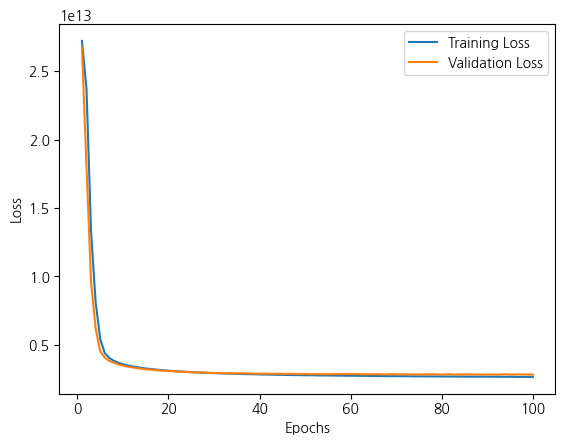

In [8]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# loss와 val_loss 값을 그래프로 그립니다.
epochs_range = range(1, len(loss) + 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()